# Event Centering 2021-04-14

Goal of this notebook is to test out functions for event centering on 1 day, 1 neuron. And then, 1 day, all neurons. And then all days all neurons. Plan is to save out as dicts (nested) to used for later analysis specific to delay period analysis.

### Libs & Utils

In [1]:
# libraries
import sys; sys.path.insert(0, '..') # if you don't find it here, look one above
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.io as spio
import pickle
from tqdm import tqdm
from scipy import stats
# stored one repo up in my fork of Spykes
# from spykes.spykes.plot.neurovis import NeuroVis
from io_utils import *
from plotting_utils import * 


# settings
%load_ext autoreload
%autoreload 2
sns.set_context("talk")

### Load session

Here, I'm loading in one session (08-06-2019) that has 4 cells 

In [54]:
sess_name = 'W122_08_06_2019_1_fromSD'

base_path  = 'Y:\jbreda\ephys\post_sort_analysis\sorted_pre_bdata' 
beh_mat   = 'protocol_info.mat'
spks_mat  = 'ksphy_clusters_foranalysis.mat'

# create paths
sess_path = os.path.join(base_path, sess_name)
beh_path  = os.path.join(sess_path, beh_mat)
spks_path = os.path.join(sess_path, spks_mat)
# fig_save_path = os.path.join(os.getcwd(), 'figures', 'neurovis', sess_name)

# alginment info (hard coded here & in fx)
names = ['aud1on', 'aud1off', 'aud2on', 'aud2off', 'trial_all', 
         'delay2s', 'trial2s', 'delay4s', 'trial4s']
windows = [[-400, 600], [-500, 500], [-400, 600], [-500, 500], [-100, 5000],
           [-150, 2150],[-200, 2400], [-150, 4150], [-200, 4400]]

align_windows = dict(zip(names,windows))


# load & wrangle
beh_df, spks_dict = load_and_wrangle(beh_path, spks_path, overwrite=False)
delay_analysis_df = beh_df[(beh_df['delay'] != 6) & (beh_df['first_sound'] != 'psycho') &
                                     (beh_df['hit_hist'] != 'viol')]

sess_aligned = event_align_session(spks_dict, delay_analysis_df, sess_path, overwrite=True, 
                                   file_name='delay_analysis_aligned_spks.pkl')

no file found, running alignment for session


In [3]:
neuron_t = split_spks_by_trial(spks_dict['spk_times'][0], beh_df)
neuron_a = sess_aligned[1]

### PSTHs

Stopped here--- TODO:
* fix legend
* make a fx to wrap around for saving?
* make 2s and 4s delay plots for all neurons in session
    * remove psycho from event_centering
* expand to multiple neurons
* expand to multiple sessions

### make into fx

Note: for delay plots, will want to save the mean firing rate as well to make another mean. So maybe so something like spykes where raster saves out and plot option can be toggled

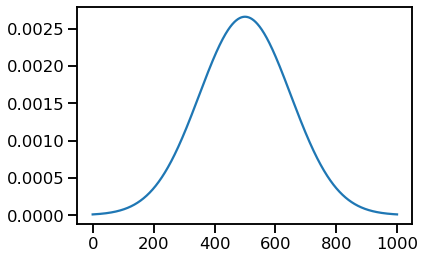

In [82]:
x = np.zeros(1000)
x[500] = 1
from scipy.ndimage import gaussian_filter1d

scipy_kernal = gaussian_filter1d(x, 150, mode='constant')
plt.plot(scipy_kernal)

In [ ]:
sess_aligned[0]['delay']

<module 'numpy' from 'C:\\Users\\JB\\anaconda3\\envs\\PWM_ephys\\lib\\site-packages\\numpy\\__init__.py'>

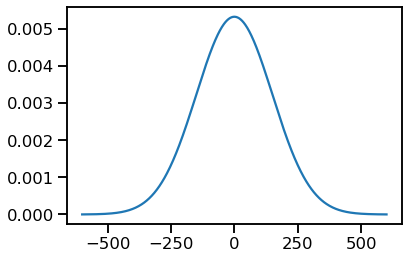

In [5]:
mu = 0
sigma = 150
f = 4
x = np.linspace(-int(sigma*f), int(sigma*f), sigma*4)
plt.plot(x, make_gaussian_kernal(x,mu,sigma))
np

In [61]:
del_2_df = delay_analysis_df[(delay_analysis_df['delay'] == 2)] # & (beh_df['first_sound'] != 'psycho')]
del_4_df =delay_analysis_df[(delay_analysis_df['delay'] == 4)]

In [62]:
del_2_df

,trial_num,hit_hist,delay,pair_hist,correct_side,prev_side,aud1_sigma,aud2_sigma,c_poke,end_state,hit_state,aud1_on,aud1_off,aud2_on,aud2_off,louder,first_sound
0,15,hit,2,4,RIGHT,LEFT,0.053144,0.019683,519.086082,524.267078,523.067086,519.136082,519.536082,521.536087,521.936083,aud_1,0.0531*
4,20,hit,2,1,RIGHT,LEFT,0.002700,0.001000,570.250080,575.399077,574.317085,570.300083,570.700080,572.701084,573.100081,aud_1,0.0027
6,23,hit,2,1,RIGHT,RIGHT,0.002700,0.001000,596.990080,602.193083,601.003078,597.041082,597.441072,599.441076,599.841086,aud_1,0.0027
15,33,hit,2,7,LEFT,RIGHT,0.007290,0.019683,701.775077,707.133076,705.833081,701.825079,702.226089,704.225089,704.625079,aud_2,0.0073
20,39,hit,2,7,LEFT,RIGHT,0.007290,0.019683,764.498082,769.665077,768.386080,764.549088,764.949080,766.948089,767.349082,aud_2,0.0073
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,554,hit,2,4,RIGHT,RIGHT,0.053144,0.019683,5890.620080,5895.875075,5894.746078,5890.670082,5891.070080,5893.071070,5893.471083,aud_1,0.0531*
375,556,hit,2,2,RIGHT,LEFT,0.007290,0.002700,5917.566091,5922.848083,5921.646089,5917.616092,5918.016091,5920.017086,5920.417079,aud_1,0.0073
377,558,miss,2,5,LEFT,LEFT,0.001000,0.002700,5940.456092,5945.512078,5944.168082,5940.507087,5940.907076,5942.907076,5943.307072,aud_2,0.0001*
385,571,hit,2,6,LEFT,RIGHT,0.002700,0.007290,6048.656078,6053.867073,6052.617088,6048.706080,6049.106082,6051.106083,6051.506080,aud_2,0.0027


I'm not sure which kernal is better. I like the ease of the scipy stats kernal and how it truncates at 4 sd, but I worry that the area will not be equal to 1 and this is supressing the firing rate artificially. Update: in comparison with my homemade kernal given similar params and mode='constant', the firing rate between the two convolutions is similarly supressed. Overall, it seems like the 'wrap' mode best replicates the boxcar

No handles with labels found to put in legend.


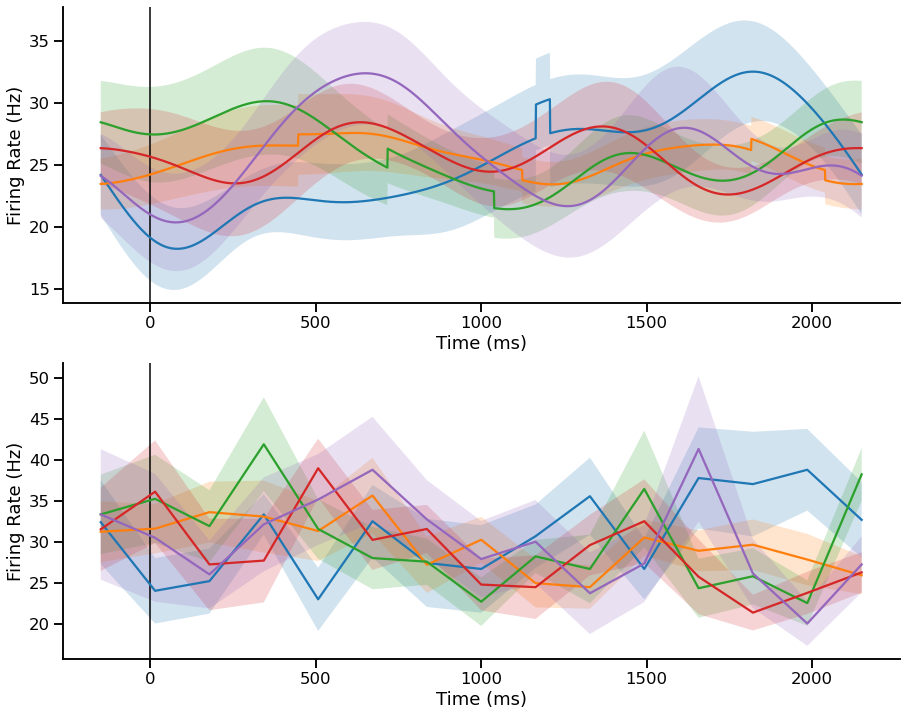

In [63]:
n = 0
b = PSTH_boxcar(sess_aligned[n], align_windows, 'delay2s', del_2_df, conditions='first_sound', bin_size=0.150)

g = PSTH_gaussain(sess_aligned[n], align_windows, 'delay2s', del_2_df, conditions='first_sound', x=x, mu=mu, sigma=sigma )

fig, ax = plt.subplots(2, 1, figsize = (15, 12))

plot_psth(g,axis=ax[0], legend=True)
plot_psth(b,axis=ax[1])

I want to now take the PSTH dict output above and make the plot that carlos has asked for with first sound on x axis and average firing rate on y axis.

Update: this is okay, but I should probably do it for each cond and store (ie from data not from mean) to get a better idea of waht is going on. Ideally, this could be stored in a df for using seaborn..?

In [ ]:
def fr_by_loudness(psth, neuron_id):
    
    

In [20]:
g['data'].keys()

dict_keys(['0.0001*', '0.0027', '0.0073', '0.0197', '0.0531*', 'psycho'])

In [25]:
g['data']['0.0001*'][0]

array([3.89097456, 3.84369565, 3.79683394, ..., 4.03532622, 3.98678872,
       3.93867187])

Unfortunately, this collapses it all to 5 becuase there is 1 key for x trials for a sound. I don't think the .items() iteration is the correct way to do this. This is because it's a nested dictionary. One option would be to do a nested iteration?

In [64]:
neuron_id = sess_name + '_' + str(n)
conds = []
avg_fr_by_cond = []

for key, value in g['data'].items():
    
    key = key.replace('*', '')
    conds.append(float(key))
    
    avg_fr = np.nanmean(value)
    print(len(value))
    
    avg_fr_by_cond.append(avg_fr)

11
30
17
16
12


In [75]:
for key in g['data'].keys():
    
    for trial in g['data'][key]:
        
        single_t = trial
        single_k = key
        
       

In [76]:
single_k

'0.0531*'

'W122_08_06_2019_1_fromSD_0'

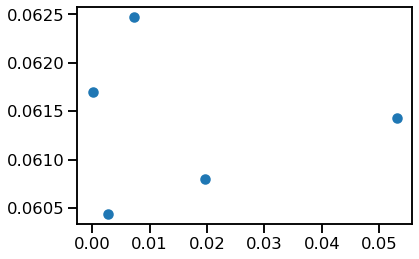

In [190]:
means = PSTH['mean']
label = []
avg = []
for key, val in means.items():
    
    key = key.replace('*','')
    label.append(float(key))
    
    avg.append(np.mean(val))

plt.scatter(label, avg)

### Rasters

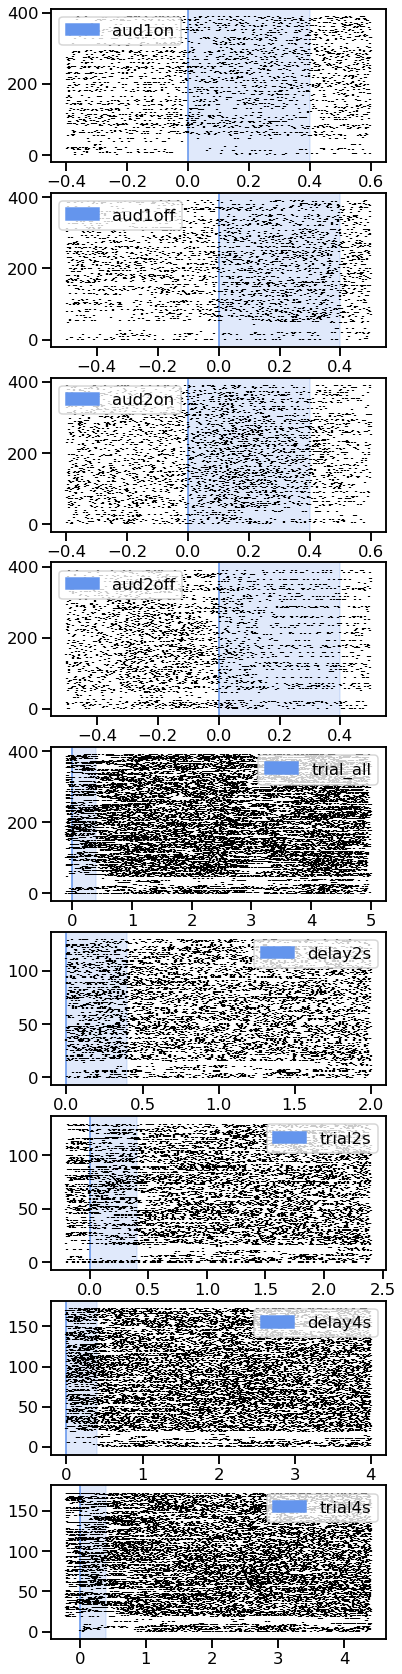

In [65]:
fig, ax = plt.subplots(len(neuron_a), 1, figsize=(6,30))

for idx, key in enumerate(neuron_a.keys()):
    _ = ax[idx].eventplot(neuron_a[key],colors = 'black')
    ax[idx].axvspan(0,0.000001, color = 'cornflowerblue', label = key)
    ax[idx].axvspan(0,0.4, alpha = 0.2, color = 'cornflowerblue')
    ax[idx].legend()
    

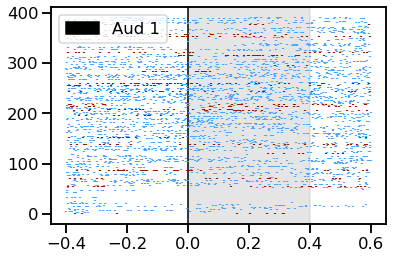

In [111]:
t = (beh_df['hit_hist'] =='hit').to_numpy()
new = np.where(t == True, '#4DA6FF', '#991900')

_ = plt.eventplot(neuron_a['aud1on'], color = new)
plt.axvspan(0,0.4, alpha = 0.2, color = 'grey')
plt.axvspan(0,0.000001, color = 'black', label = 'Aud 1')
plt.legend()

## non function code

In [83]:
test = binarize_event(sess_aligned[2]['delay2s'],[-150,2150], 0.001)
mu = 0
sigma = .150
x = np.linspace(-1.0, 1.0, 150)
ker = make_gaussian_kernal(x, mu, sigma)

# make kernal
kernal = make_gaussian_kernal(x, mu, sigma)

# convolve 
m, s, tr = smooth_trials(test, kernal, summary=True)
# for plot
time = np.linspace(-150, 2150, len(m))


No handles with labels found to put in legend.


(0.0, 2000.0)

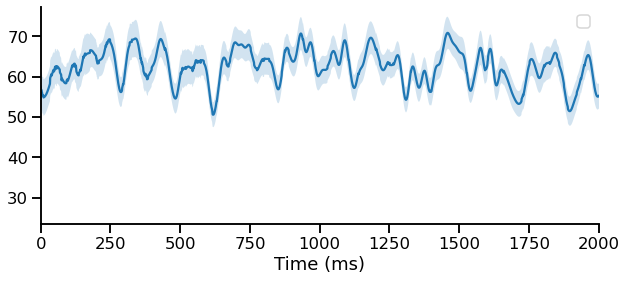

In [206]:
fig, ax = plt.subplots(figsize = (10, 4))
ax.plot(time, m)
ax.fill_between(time, m - s, m + s, alpha = 0.2 )

# plt.axvspan(0,400, alpha = 0.2, color = 'grey')
# plt.axvspan(0,0.000001, color = 'black', label = 'Aud 1')
ax.set(xlabel = "Time (ms)")
plt.legend()
sns.despine()
plt.xlim(0,2000)
# plt.ylim(0.01, 0.05)

#### scipy stats

seems not to work when y axis output is < 1 

In [59]:
# these are names in the beh_df
df_event = ['aud1_on', 'aud1_off', 'aud2_on', 'aud2_off', 'aud1_on']
names = ['aud1on', 'aud1off', 'aud2on', 'aud2off', 'trial_all']
windows = [[-400, 600], [-500, 500], [-400, 600], [-500, 500], [-100, 5000]]


aligned_spk_times = {}

for event,name,window in zip(df_event,names,windows):
    rowsL = []
    aligned_spk_times[name] = []
    
    for itrial, row in beh_df.iterrows():
        
        trial_spks = neuron1_spks['trial_spks'][itrial]

        # grab alignment time
        align_time = row[event]
        
        # create windows
        start = align_time + (window[0] * 0.001)
        stop  = align_time + (window[1] * 0.001)  
        
         # grab spks in the window
        spks_in_window = trial_spks[np.logical_and(trial_spks > start, trial_spks < stop)]
        event_aligned = spks_in_window - align_time
        
        # append
        aligned_spk_times[name].append(event_aligned)
        

In [102]:
# delay

def delay_align(beh_df, trial_spks):
    delay_windows = [[0, 2000],[-200, 2400], [0, 4000], [-200, 4400]]
    delay_names = ['delay2s', 'trial2s', 'delay4s', 'trial4s']


L =[[],[],[],[]]


    for itrial, row in beh_df.iterrows():

        trial_spks = neuron1_spks['trial_spks'][itrial]
        d_align_time = row['aud1_off']
        t_align_time = row['aud1_on']

        if row['delay'] == 2:

            d = 0
            d_start  = d_align_time + (delay_windows[d][0] * 0.001)
            d_stop   = d_align_time + (delay_windows[d][1] * 0.001)

            spks_in_delay = trial_spks[np.logical_and(trial_spks > d_start, trial_spks < d_stop)]
            delay_aligned = spks_in_delay - d_align_time
            L[d].append(delay_aligned)

            t = 1
            t_start  = t_align_time + (delay_windows[t][0] * 0.001)
            t_stop   = t_align_time + (delay_windows[t][1] * 0.001)

            spks_in_trial = trial_spks[np.logical_and(trial_spks > t_start, trial_spks < t_stop)]
            trial_aligned = spks_in_trial - t_align_time
            L[t].append(trial_aligned)

        elif row['delay'] == 4:

            d = 2 
            d_start  = d_align_time + (delay_windows[d][0] * 0.001)
            d_stop   = d_align_time + (delay_windows[d][1] * 0.001)

            spks_in_delay = trial_spks[np.logical_and(trial_spks > d_start, trial_spks < d_stop)]
            delay_aligned = spks_in_delay - d_align_time
            L[d].append(delay_aligned)

            t = 3
            t_start  = t_align_time + (delay_windows[t][0] * 0.001)
            t_stop   = t_align_time + (delay_windows[t][1] * 0.001)

            spks_in_trial = trial_spks[np.logical_and(trial_spks > t_start, trial_spks < t_stop)]
            trial_aligned = spks_in_trial - t_align_time
            L[t].append(trial_aligned)


    delay_info = dict(zip(delay_names, L))